# Step 1. Read and parse the data, then define an oscillatory function to model the tidal changes·

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime
import re

In [2]:
file_path = 'ASTR19_S22_group_project_data.txt'


def parse_time(time_str):
    return datetime.strptime(time_str, '%H:%M').time()


def convert_to_hours(day, time):
    # return day + (time.hour * 60 + time.minute) / (24 * 60)
    return (day - 1) * 24 + time.hour + time.minute / 60

In [3]:
# Step 1. Read and parse the data, then define an oscillatory function to model the tidal changes
# Read and parse the data
data = []
with open(file_path, 'r') as file:
    for line in file:
        if not line.startswith('#'):
            parts = re.split(r'\s+', line.strip())
            day = int(parts[0])
            time = parse_time(parts[1])
            tide_height = float(parts[2])
            time_in_hours = convert_to_hours(day, time)
            data.append((time_in_hours, tide_height))

# Convert data into a DataFrame
df = pd.DataFrame(data, columns=['Time (hours)', 'Tide Height (ft)'])


# Define an oscillatory function: A * sin(B * t + C) + D + E * sin(F * t + G)
def oscillatory_func(t, A, B, C, D, E, F, G):
    return A * np.sin(B * t + C) + D + E * np.sin(F * t + G)

# Step 2: Fit and plot the model

Initial guesses: [5, 0.5235987755982988, 0, 0, 0, 0.2617993877991494, 0]
Fitted parameters: [-0.94413163  0.52422121 -0.63585185  2.58965329  2.83626918  0.26184293
 -0.01969398]


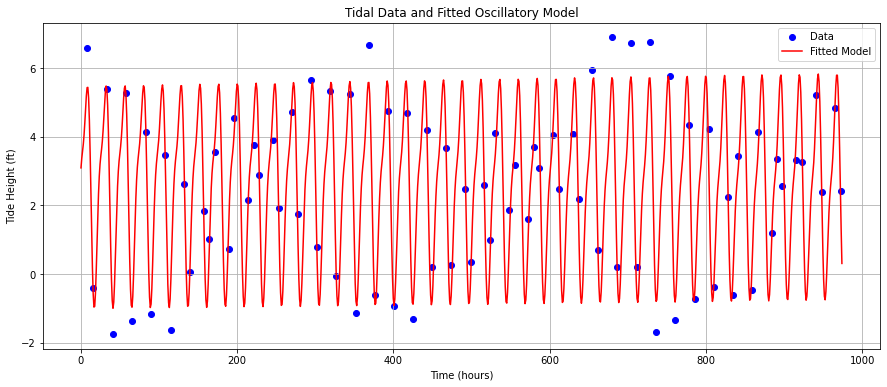

In [4]:
# initial_guesses = [5, 2 * np.pi / 12, 0, 0]  # 12 is an approximate tidal period in hours
initial_guesses = [5, 2 * np.pi / 12, 0, 0, 0, 2 * np.pi / 24, 0]
print('Initial guesses: {}'.format(initial_guesses))
experimental_error = 0.25  # Root mean squared experimental error in feet

params, _ = curve_fit(oscillatory_func, df['Time (hours)'], df['Tide Height (ft)'], p0=initial_guesses,
                      sigma=experimental_error * np.ones(len(df['Time (hours)'])),
                      absolute_sigma=True)
print('Fitted parameters: {}'.format(params))

# Plotting the data and the fitted model
plt.figure(figsize=(15, 6))
plt.scatter(df['Time (hours)'], df['Tide Height (ft)'], label='Data', color='blue')
x_vals = np.linspace(0, int(df['Time (hours)'].max()) + 1, 1000)
# x_vals = df['Time (hours)']
plt.plot(x_vals, oscillatory_func(x_vals, *params), label='Fitted Model', color='red')
# for i in range(1, 15):
#     plt.axvline(x=i * 24, color='black', linestyle='--')

plt.xlabel('Time (hours)')
plt.ylabel('Tide Height (ft)')
plt.title('Tidal Data and Fitted Oscillatory Model')
plt.legend()
plt.grid(True)
plt.savefig('model_fit.pdf')

# Step 3: Residuals

Standard deviation of residuals: 0.666 ft
The scatter in the data is larger than the assumed experimental error.
Intrinsic scatter: 0.617 ft


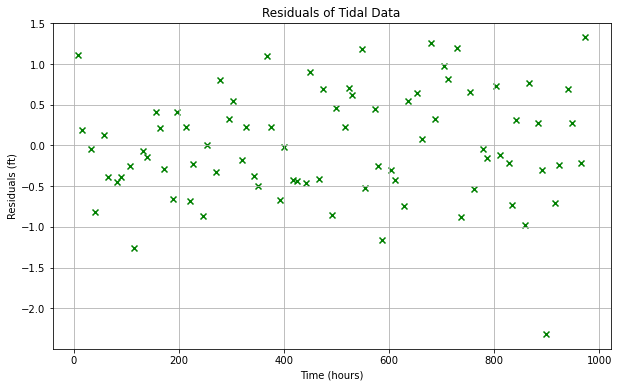

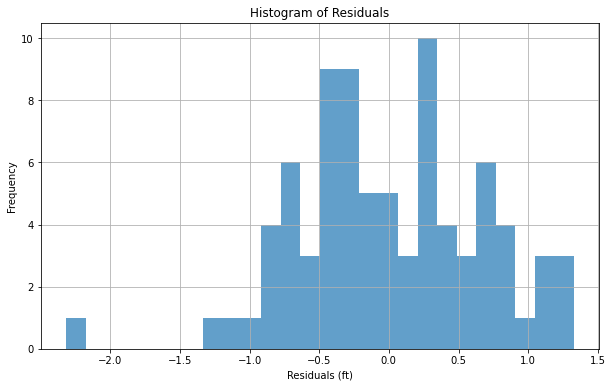

In [5]:
df['Residuals'] = df['Tide Height (ft)'] - oscillatory_func(df['Time (hours)'], *params)
std_dev = df['Residuals'].std()
print('Standard deviation of residuals: {:.3f} ft'.format(std_dev))

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['Time (hours)'], df['Residuals'], label='Residuals', color='green', marker='x')
plt.xlabel('Time (hours)')
plt.ylabel('Residuals (ft)')
plt.title('Residuals of Tidal Data')
plt.grid(True)
plt.savefig('figs/residuals_scatter.pdf')

# Is the scatter in the data larger than the assumed experimental error?
if std_dev <= experimental_error:
    print('The scatter in the data is equal to or smaller than the assumed experimental error.')
else:
    print('The scatter in the data is larger than the assumed experimental error.')

intrinsic_scatter = np.sqrt(std_dev ** 2 - experimental_error ** 2) if std_dev > experimental_error else 0
print('Intrinsic scatter: {:.3f} ft'.format(intrinsic_scatter))

plt.show()

plt.figure(figsize=(10, 6))
bin_width = 2 * intrinsic_scatter / np.sqrt(len(df['Residuals']))
bins = int((df['Residuals'].max() - df['Residuals'].min()) / bin_width)
plt.hist(df['Residuals'], alpha=0.7, bins=bins)
plt.xlabel('Residuals (ft)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.savefig('figs/residuals_histogram.pdf')